## Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torch.utils.data import Dataset, DataLoader, random_split
import copy


cudnn.benchmark = True
plt.ion()

Load data and create Dataloaders

In [2]:
from utils import SymbolDataset, encode_labels

data_dir = 'symbols_2000.npz'
data = np.load(data_dir)
images = data['images']
labels = data['labels']

class_names, labels_nums = encode_labels(labels)

images_tensor = torch.tensor(images).float()

# NOTE: maybe try different mean and stds?
# mean and std from imagenet are as follows:
#  - mean = 0.4453
#  - std  = 0.2692

# Calculate the mean and standard deviation
mean = images_tensor.mean()
std = images_tensor.std()

data_transforms = {
    'train': transforms.Compose([ # Add in transforms if needed, and add test set
        transforms.ToTensor(),
        #transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize(mean, std)
    ]),
}

# initialize symbol dataset training splits
dataset = SymbolDataset(images, labels_nums, transforms=data_transforms['train'])
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# initialize dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=4)
}
dataset_sizes = {x: len(dataset) for x in ['train', 'val']}
class_names = np.unique(labels)
num_classes = len(class_names)
print(num_classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

30


Visualize a batch of training data

torch.Size([3, 274, 274])


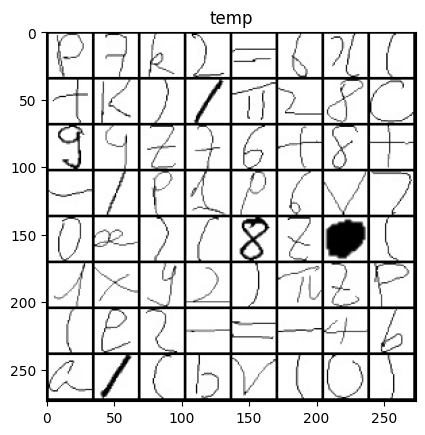

In [3]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
print(out.shape)

imshow(out, title="temp")

## Model Training

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    test_token=0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
             
            
            
            
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            count = 0 

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                count += len(labels)
                inputs = np.repeat(inputs, 3, axis=1)

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / count
            epoch_acc = running_corrects.double() / count

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                test_token =1


        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            # if it errors here u probably have to do the same grayscale to rgb stacking i did earlier
            inputs = inputs.to(device)
            labels = labels.to(device)
            inputs = inputs.repeat(1, 3, 1, 1)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
model_ft = models.wide_resnet101_2(pretrained=True)
num_ftrs = model_ft.fc.in_features

half_in_size = round(num_ftrs/2)
layer_width = 1024

/home/mihirvador/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mihirvador/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet101_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet101_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
import torch.nn as nn
import torch.nn.functional as F

class SpinalNet(nn.Module):
    def __init__(self):
        super(SpinalNet, self).__init__()
        
        self.fc_spinal_layer1 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(half_in_size, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_spinal_layer2 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_spinal_layer3 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_spinal_layer4 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_out = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(layer_width*4, num_classes),)
        
        

    def forward(self, x):
        x1 = self.fc_spinal_layer1(x[:, 0:half_in_size])
        x2 = self.fc_spinal_layer2(torch.cat([ x[:,half_in_size:2*half_in_size], x1], dim=1))
        x3 = self.fc_spinal_layer3(torch.cat([ x[:,0:half_in_size], x2], dim=1))
        x4 = self.fc_spinal_layer4(torch.cat([ x[:,half_in_size:2*half_in_size], x3], dim=1))
        
        
        x = torch.cat([x1, x2], dim=1)
        x = torch.cat([x, x3], dim=1)
        x = torch.cat([x, x4], dim=1)

        
        x = self.fc_out(x)
        return x



net_fc = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )


Summarize pre-trained ResNet18

In [8]:
from torchinfo import summary

model_ft.fc = SpinalNet()



summary(model=model_ft, 
        verbose=0,
        input_size=(64, 3, 32, 32),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])
model_ft = model_ft.to(device)

Modify last linear classification layer and freeze previous layers in preparation for transfer learning

Initialize loss criterion and training optimizer

In [9]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Training loop

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0136 Acc: 0.7377
val Loss: 0.1475 Acc: 0.9605

Epoch 1/24
----------
train Loss: 0.1817 Acc: 0.9538
val Loss: 0.0985 Acc: 0.9736

Epoch 2/24
----------
train Loss: 0.1132 Acc: 0.9707
val Loss: 0.0813 Acc: 0.9792

Epoch 3/24
----------
train Loss: 0.0753 Acc: 0.9796
val Loss: 0.0734 Acc: 0.9811

Epoch 4/24
----------
train Loss: 0.0593 Acc: 0.9838
val Loss: 0.0715 Acc: 0.9812

Epoch 5/24
----------
train Loss: 0.0515 Acc: 0.9863
val Loss: 0.0656 Acc: 0.9839

Epoch 6/24
----------
train Loss: 0.0424 Acc: 0.9872
val Loss: 0.0740 Acc: 0.9823

Epoch 7/24
----------


KeyboardInterrupt: 

Model Visualization

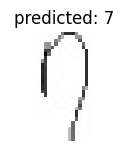

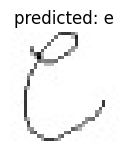

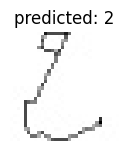

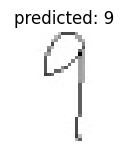

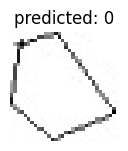

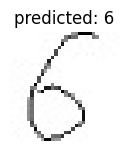

In [44]:
visualize_model(model_ft, 20)

In [61]:
torch.save(model_ft, 'transfer_model.pth')